**IMPORTS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.widgets import Slider, Button, RadioButtons
import scipy
import scipy.sparse
import scipy.sparse.linalg
import random

**INIT MESH**

In [2]:
Lx, Ly = 1, 1  # size in space
Nx, Ny = 64, 64  # Number of points in space
T = 1  # size in time
Nt = 250  # number of points in time
a = 0.1  # diffusion coefficient

# mesh points in space
x_mesh = np.linspace(0, Lx, Nx + 1)
dx_mesh = x_mesh[1] - x_mesh[0]
y_mesh = np.linspace(0, Ly, Ny + 1)
dy_mesh = y_mesh[1] - y_mesh[0]
# mesh points in time
t_mesh = np.linspace(0, T, Nt + 1)
dt_mesh = t_mesh[1] - t_mesh[0]

Fx = a * dt_mesh / dx_mesh ** 2
Fy = a * dt_mesh / dy_mesh ** 2

Fx, Fy

(1.6384, 1.6384)

**INITIAL CONDITION**

In [3]:
def I(x, y):
    return (1 if (0.2 < x < 0.8) and (0.2 < y < 0.8) else 0)

# Set initial condition
u = np.zeros((Nx + 1, Ny + 1, Nt + 1))
for x in range(0, Nx + 1):
    for y in range(0, Ny + 1): 
        u[x, y, 0] = I(x_mesh[x], y_mesh[y])


**SET UP ANIMATIONS**

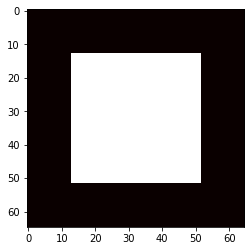

In [4]:
%matplotlib inline
from IPython.display import HTML

anim_len = 10000
anim_interval = anim_len / Nt

fig = plt.figure()
ax = plt.subplot(1, 1, 1)
l = ax.imshow(u[..., 0], cmap="hot")

def animate(i):
    y = u[..., i]
    l.set_data(y)
    return l,

**FORWARD EULER SCHEME**

In [5]:
# Compute u at inner mesh points
for t in range(0, Nt):
    for x in range(1, Nx):
        for y in range(1, Ny):
            u[x, y, t + 1] = u[x, y, t] + Fx * (u[x + 1, y, t] + u[x - 1, y, t] - 2 * u[x, y, t]) + \
                                          Fy * (u[x, y + 1, t] + u[x, y - 1, t] - 2 * u[x, y, t])
        

In [6]:
anim = animation.FuncAnimation(fig, animate, frames=Nt, interval=anim_interval, blit=True)
HTML(anim.to_jshtml())

**BACKWARD EULER SCHEME**

In [7]:
A = scipy.sparse.diags(
    diagonals=[-Fy, -Fx, 2 * Fx + 2 * Fy + 1, -Fx, -Fy], 
    offsets=[-Ny - 1, -1, 0, 1, Ny + 1], 
    shape=((Nx + 1) * (Ny + 1), (Nx + 1) * (Ny + 1)), 
    format="csr"
)

# Boundary conditions
for t in range(Ny + 2):
    A[t + 1, t] = 0
    A[t, t + 1] = 0
    
    A[t + Ny + 1, t] = 0
    A[t, t + Ny + 1] = 0


for t in range(Ny * 2, (Nx + 1) * (Ny + 1) - Ny * 2 - 3, Ny + 1):
    A[t + 1, t] = 0
    A[t, t + 1] = 0
    A[t + 2, t + 1] = 0
    A[t + 1, t + 2] = 0
    A[t + 3, t + 2] = 0
    A[t + 2, t + 3] = 0
    
    A[t + Ny + 1, t] = 0
    A[t, t + Ny + 1] = 0
    A[t + Ny + 2, t + 1] = 0
    A[t + 1, t + Ny + 2] = 0
    A[t + Ny + 3, t + 2] = 0
    A[t + 2, t + Ny + 3] = 0


for t in range((Nx + 1) * (Ny + 1) - Ny - 3, (Nx + 1) * (Ny + 1) - 1):
    A[t + 1, t] = 0
    A[t, t + 1] = 0
    
    A[t - Ny - 1, t] = 0
    A[t, t - Ny - 1] = 0
    

In [8]:
for t in range(1, Nt):
    # Compute b and solve linear system
    u[..., t] = scipy.sparse.linalg.spsolve(A, u[..., t - 1].flatten()).reshape(Nx + 1, Ny + 1)

In [9]:
anim = animation.FuncAnimation(fig, animate, frames=Nt, interval=anim_interval, blit=True)
HTML(anim.to_jshtml())